# Trying the gluonts rolling window module

In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model,preprocessing
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions
config=Configuration()
df=pd.read_csv("Influenza.csv",sep=',')

In [6]:
locations=list(df.location.unique())[:10]
#Process the df into a uniformly spaced df
one_ts_df=df.loc[df.location.isin(locations),["value",'location','date']]
one_ts_df=preprocessing(config,one_ts_df,check_count=False,output_type="corrected_df")

#seperate the intervals for training and testing
train_set=one_ts_df.loc[(one_ts_df.index<=config.train_end_time) &(one_ts_df.index>=config.train_start_time),:]
test_set=one_ts_df.loc[(one_ts_df.index>=config.train_start_time) &(one_ts_df.index<=config.test_end_time),:]# Ist genau 104 Lang
start_time=min(test_set.index.difference(train_set.index))
end_time=max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set=PandasDataset.from_long_dataframe(dataframe=train_set,item_id='location', target="value",freq=config.freq)
test_set=PandasDataset.from_long_dataframe(dataframe=test_set,item_id='location', target="value",freq=config.freq)

test_set = generate_rolling_dataset(
    dataset=test_set,
    strategy = StepStrategy(prediction_length=4,step_size=1),
    start_time = pd.Period(start_time,config.freq),
    end_time = pd.Period(end_time,config.freq)
)
print(len(test_set)/len(locations))

101.0


100%|██████████| 50/50 [00:07<00:00,  6.95it/s, epoch=4/4, avg_epoch_loss=0.738]


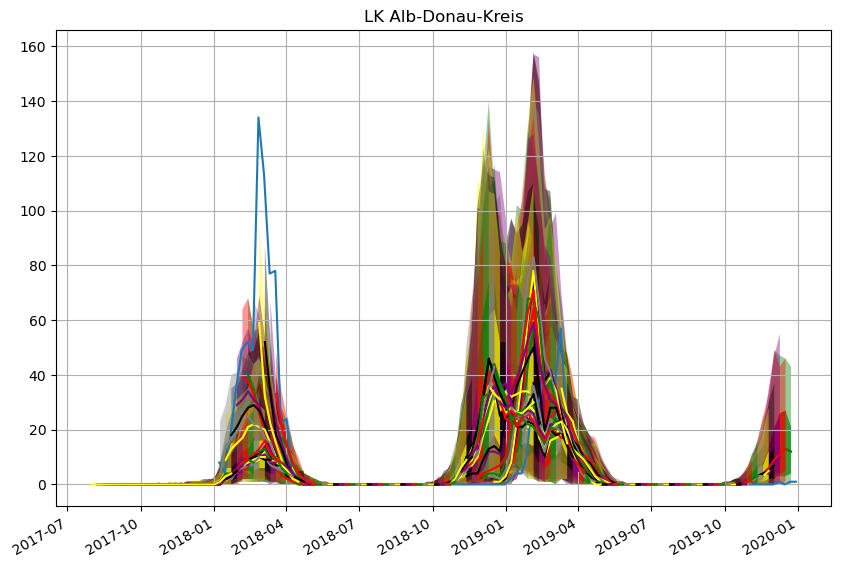

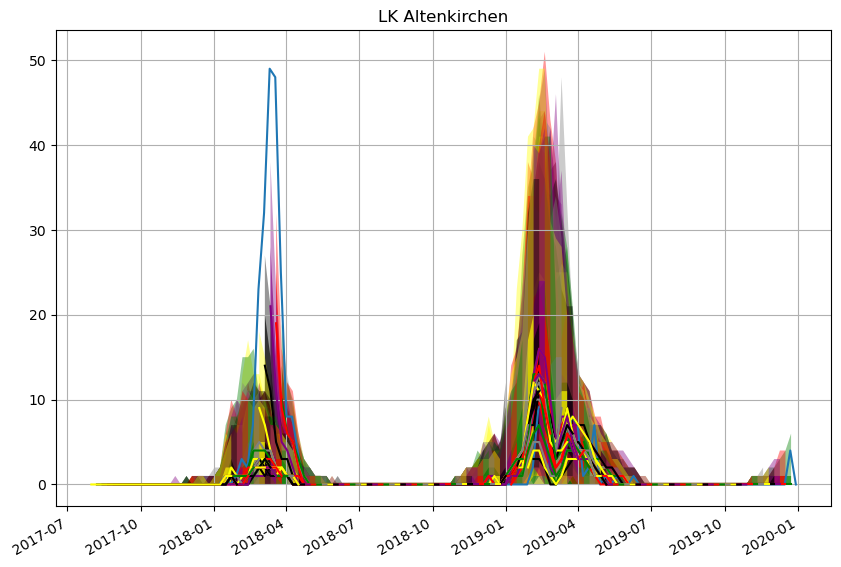

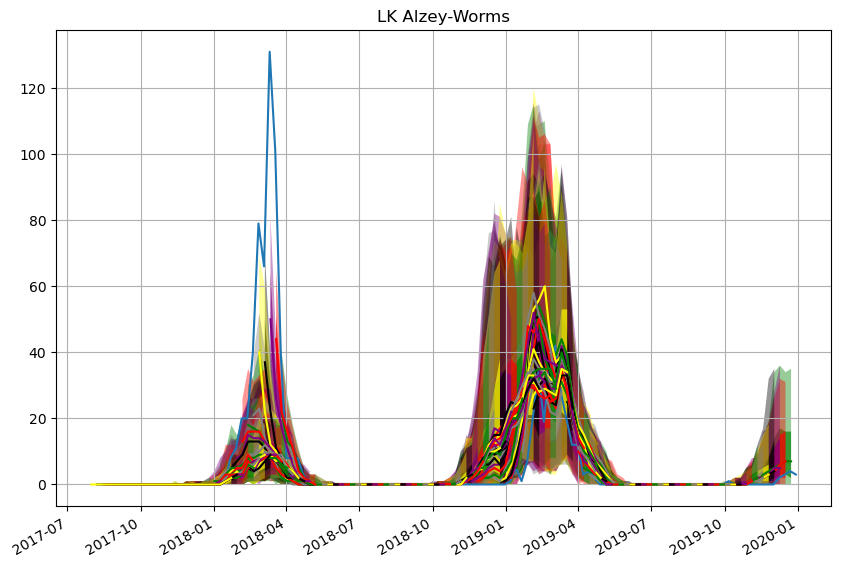

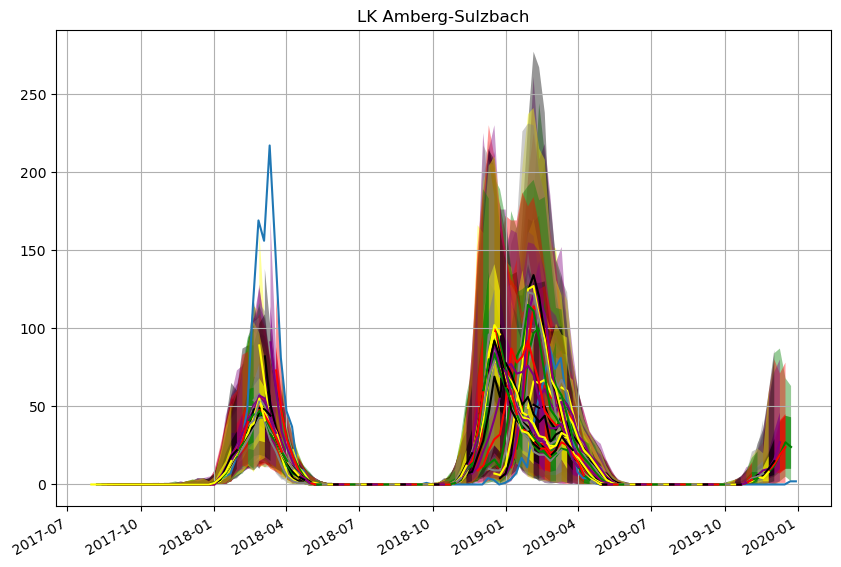

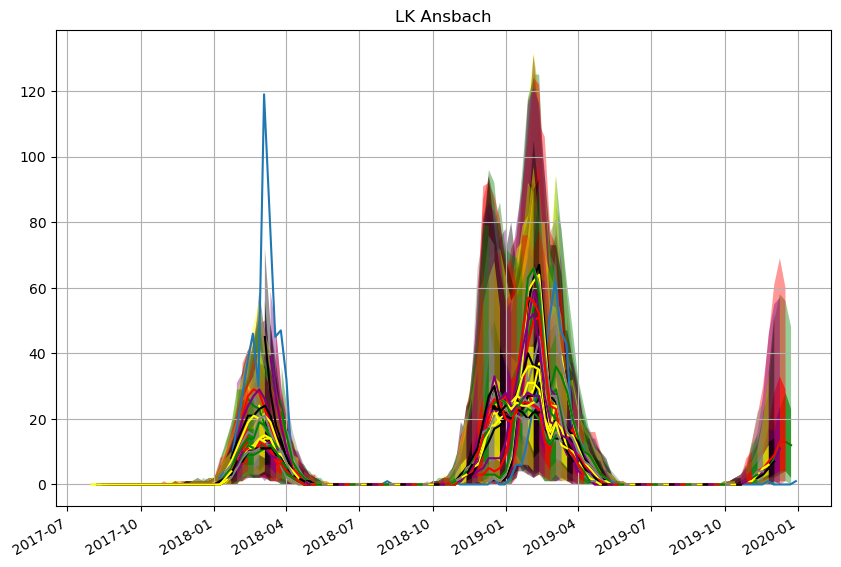

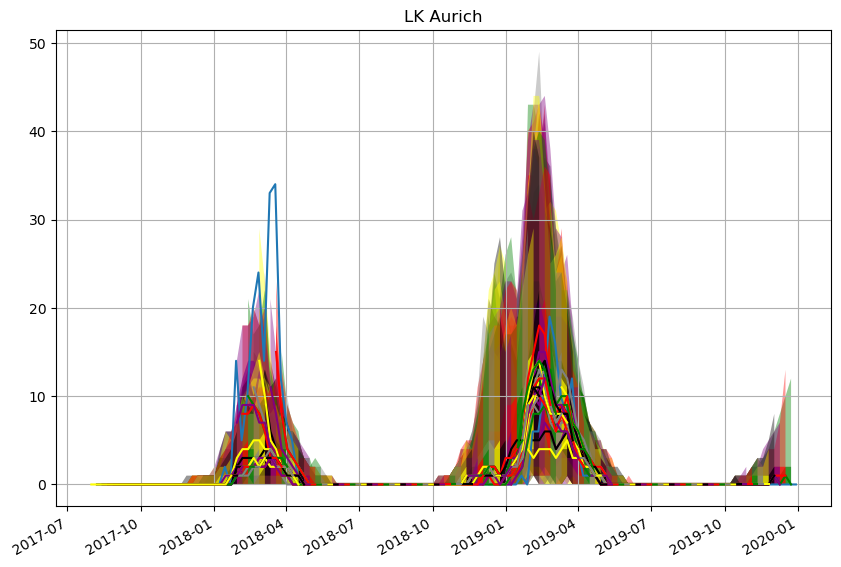

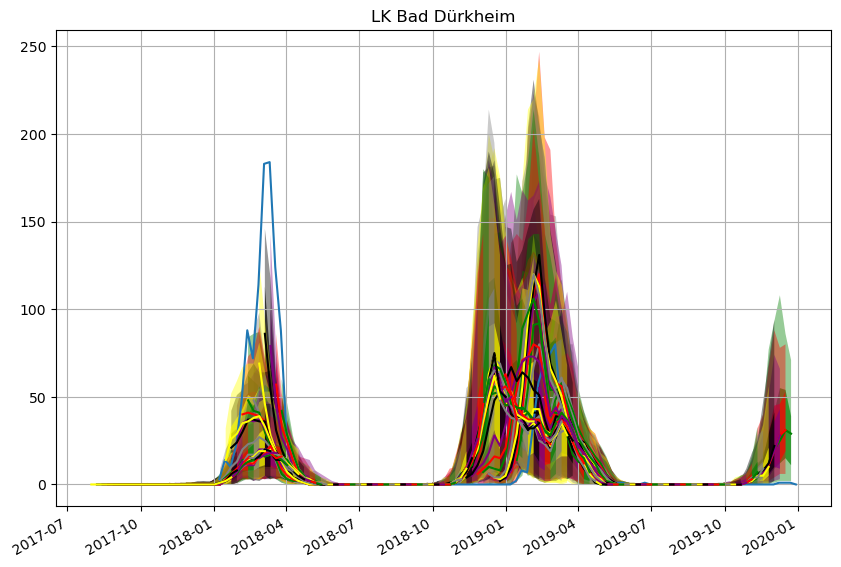

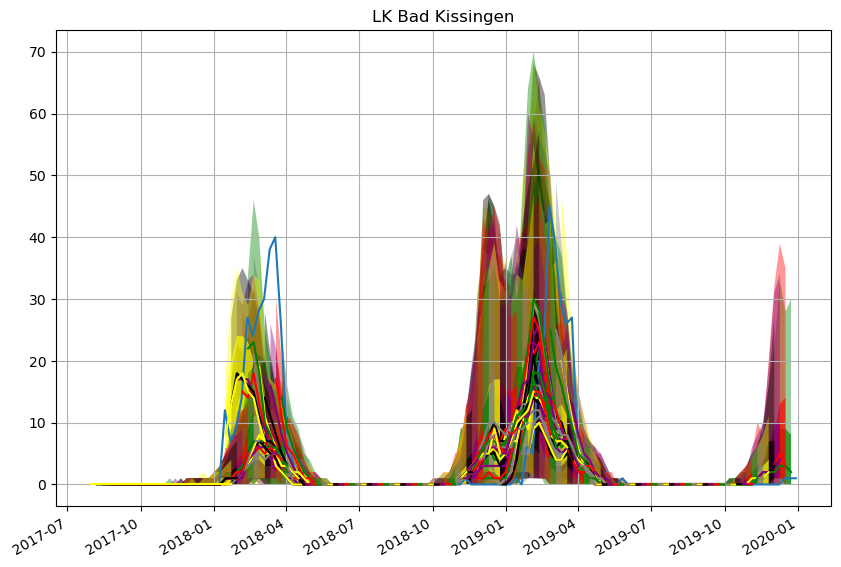

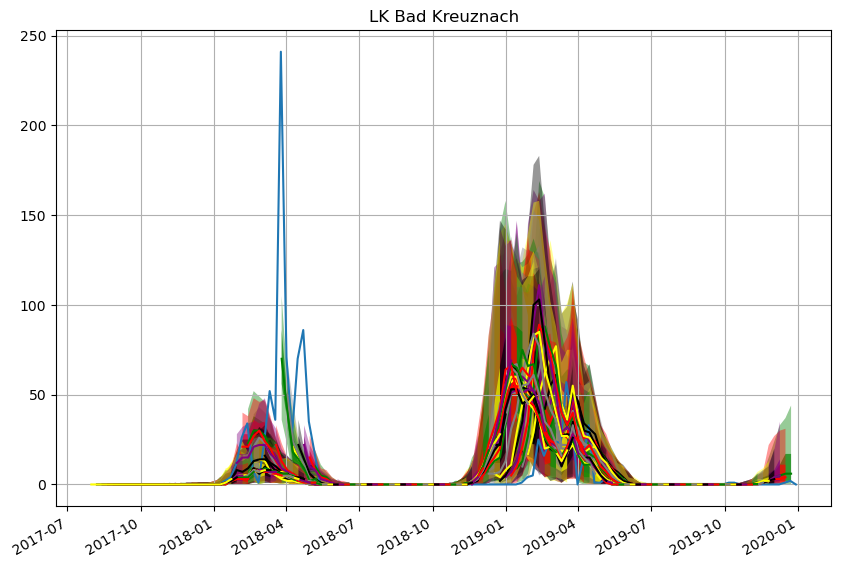

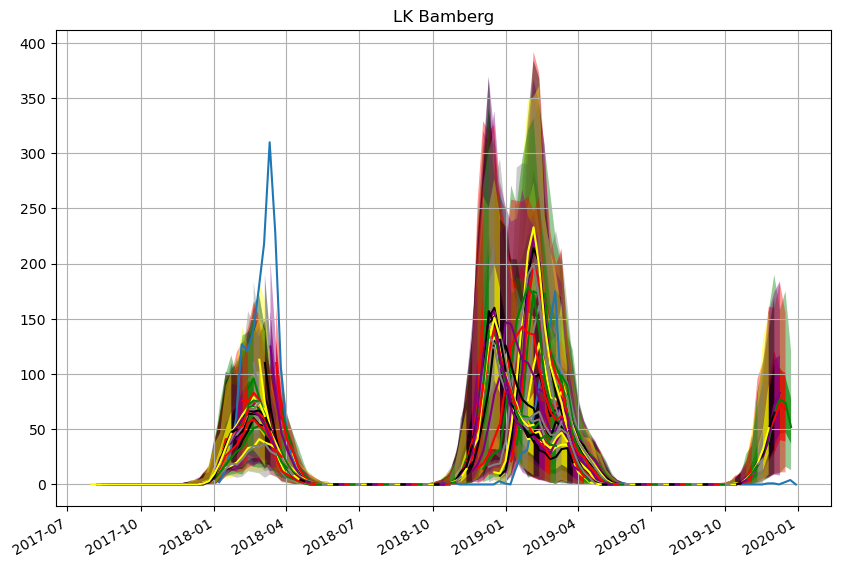

'\nNOTE: the "missing" predictions in between different window plots aren\'t actually missing, \nas the predictions just aren\'t connected with an line. This is due to the seperate plotting of each window.\nIf we would use scatter plots, there would be no visual problem with the predictions.\n'

In [9]:
#train and evaluate the model
forecasts,tss=model(config,train_set,test_set)
windows_per_location=int(len(test_set)/len(locations))
for location in locations:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location']==location)&(one_ts_df.index<=config.test_end_time) &(one_ts_df.index>=config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location']==location)&(one_ts_df.index<=config.test_end_time) &(one_ts_df.index>=config.train_end_time),'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color=["g","r","purple",'black','yellow','grey']*windows_per_location
    for k in range(0 + windows_per_location*locations.index(location),windows_per_location + windows_per_location*locations.index(location)):
        ts_entry=tss[k]
        forecast_entry=forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k%windows_per_location])
    plt.grid(which="both")
    plt.show()
"""
NOTE: the "missing" predictions in between different window plots aren't actually missing, 
as the predictions just aren't connected with an line. This is due to the seperate plotting of each window.
If we would use scatter plots, there would be no visual problem with the predictions.
"""

In [10]:
from gluonts.evaluation import Evaluator
evaluator=Evaluator(quantiles=[0.1,0.2,0.5,0.8,0.9])
agg_metrics, item_metrics = evaluator(tss,forecasts)
#print(json.dumps(agg_metrics, indent=4))
#print(item_metrics.head())
print(item_metrics[item_metrics.item_id == "LK Bad Dürkheim"])

Running evaluation: 1010it [00:00, 1425.60it/s]


             item_id         forecast_start         MSE  abs_error  \
606  LK Bad Dürkheim  2019-07-01/2019-07-07  183.791222      128.0   
607  LK Bad Dürkheim  2019-06-24/2019-06-30  148.353516      102.0   
608  LK Bad Dürkheim  2019-06-17/2019-06-23   71.475271       73.0   
609  LK Bad Dürkheim  2019-06-10/2019-06-16   61.833966       52.0   
610  LK Bad Dürkheim  2019-06-03/2019-06-09   18.659311       24.0   
..               ...                    ...         ...        ...   
702  LK Bad Dürkheim  2017-08-28/2017-09-03  783.858474      321.0   
703  LK Bad Dürkheim  2017-08-21/2017-08-27  403.411133      214.0   
704  LK Bad Dürkheim  2017-08-14/2017-08-20  289.690580      161.0   
705  LK Bad Dürkheim  2017-08-07/2017-08-13   76.088125       82.0   
706  LK Bad Dürkheim  2017-07-31/2017-08-06   17.908992       44.0   

     abs_target_sum  abs_target_mean  seasonal_error      MASE       MAPE  \
606             3.0         0.115385        2.430353  2.025663  24.333333   
607  

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


## Analysis of the "missing" plotted prediction connections

In [5]:
print(forecasts[0].index)
print(tss[0])
print(forecasts[1].index)
print(forecasts[1].median)
print(forecasts[2].index)
print(forecasts[2].median)
print(forecasts[3].index)
print(forecasts[3].median)

'''
print( pd.Period(start_time,config.freq),pd.Period(end_time,config.freq))
start_time1 = pd.Period(config.train_end_time,config.freq)
end_time1 = pd.Period(config.test_end_time,config.freq)
print(start_time1,end_time1)
print(test_set)'''

PeriodIndex(['2019-07-01/2019-07-07', '2019-07-08/2019-07-14',
             '2019-07-15/2019-07-21', '2019-07-22/2019-07-28',
             '2019-07-29/2019-08-04', '2019-08-05/2019-08-11',
             '2019-08-12/2019-08-18', '2019-08-19/2019-08-25',
             '2019-08-26/2019-09-01', '2019-09-02/2019-09-08',
             '2019-09-09/2019-09-15', '2019-09-16/2019-09-22',
             '2019-09-23/2019-09-29', '2019-09-30/2019-10-06',
             '2019-10-07/2019-10-13', '2019-10-14/2019-10-20',
             '2019-10-21/2019-10-27', '2019-10-28/2019-11-03',
             '2019-11-04/2019-11-10', '2019-11-11/2019-11-17',
             '2019-11-18/2019-11-24', '2019-11-25/2019-12-01',
             '2019-12-02/2019-12-08', '2019-12-09/2019-12-15',
             '2019-12-16/2019-12-22', '2019-12-23/2019-12-29'],
            dtype='period[W-SUN]')
                         0
2009-12-28/2010-01-03  1.0
2010-01-04/2010-01-10  3.0
2010-01-11/2010-01-17  1.0
2010-01-18/2010-01-24  2.0
2010-01-25

'\nprint( pd.Period(start_time,config.freq),pd.Period(end_time,config.freq))\nstart_time1 = pd.Period(config.train_end_time,config.freq)\nend_time1 = pd.Period(config.test_end_time,config.freq)\nprint(start_time1,end_time1)\nprint(test_set)'

In [6]:
length_df=pd.DataFrame(columns=['item_id','length'])
for ts in test_set:
    index=len(length_df)
    length_df.loc[index,'item_id']=ts['item_id']
    length_df.loc[index,['length']]=len(ts['target'])
    periods=pd.date_range(start="2009-12-28", periods=len(ts['target']), freq='W-SUN')
    length_df.loc[index,'start']=periods[-config.prediction_length:].min()
    length_df.loc[index,['end_date']]=periods.max()
display(length_df)  

,item_id,length,start,end_date
0,LK Alb-Donau-Kreis,522,2019-07-07,2019-12-29 00:00:00
1,LK Alb-Donau-Kreis,496,2019-01-06,2019-06-30 00:00:00
2,LK Alb-Donau-Kreis,470,2018-07-08,2018-12-30 00:00:00
3,LK Alb-Donau-Kreis,444,2018-01-07,2018-07-01 00:00:00
